In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('04-image-classification-ccn')
jovian.set_colab_id('1GsCDVSVco4Cd4ANgbB2gamNH9P4_1aS9')

     |████████████████████████████████| 71kB 7.8MB/s 


# Image Classification using CCN


We use CIFAR10 dataset in this notebook

# Imports

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [3]:
project_name = '05-cifar10-ccn'

# Download and Explore Images

We can download the dataset from the link in .png format using download_url function

In [4]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

In [5]:
# Extract the archive
with tarfile.open('./cifar10.tgz','r:gz') as tar:
  tar.extractall(path='./data')

In [6]:
data_dir ='./data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['train', 'test']
['dog', 'bird', 'cat', 'automobile', 'airplane', 'truck', 'deer', 'frog', 'ship', 'horse']


In [7]:
num_classes = len(classes)

In [8]:
for i in classes:
  print("Number of images in train/",i," is ",len(os.listdir(data_dir+'/train/'+i)))

Number of images in train/ dog  is  5000
Number of images in train/ bird  is  5000
Number of images in train/ cat  is  5000
Number of images in train/ automobile  is  5000
Number of images in train/ airplane  is  5000
Number of images in train/ truck  is  5000
Number of images in train/ deer  is  5000
Number of images in train/ frog  is  5000
Number of images in train/ ship  is  5000
Number of images in train/ horse  is  5000


In [9]:
for i in classes:
  print("Number of images in test/",i," is ",len(os.listdir(data_dir+'/test/'+i)))

Number of images in test/ dog  is  1000
Number of images in test/ bird  is  1000
Number of images in test/ cat  is  1000
Number of images in test/ automobile  is  1000
Number of images in test/ airplane  is  1000
Number of images in test/ truck  is  1000
Number of images in test/ deer  is  1000
Number of images in test/ frog  is  1000
Number of images in test/ ship  is  1000
Number of images in test/ horse  is  1000


In [10]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [11]:
train_dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [12]:
len(train_dataset)

50000

In [13]:
image, label = train_dataset[10]
print(image.shape, label )

torch.Size([3, 32, 32]) 0


In [14]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
classes = train_dataset.classes

In [16]:
import matplotlib.pyplot as plt

In [17]:
def show_image(img, label):
  plt.figure(figsize=(10,8))
  print("The label is :",classes[label])
  plt.imshow(img.permute(1,2,0))

The label is : airplane


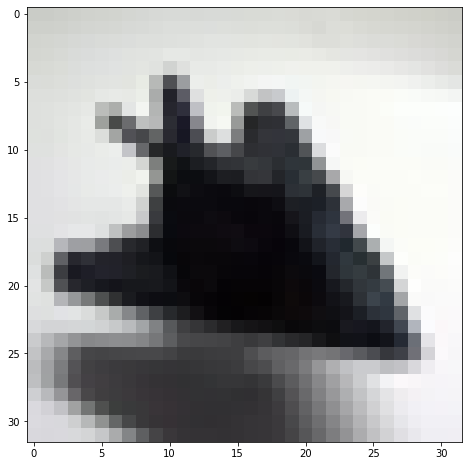

In [18]:
show_image(*train_dataset[0])

The label is : airplane


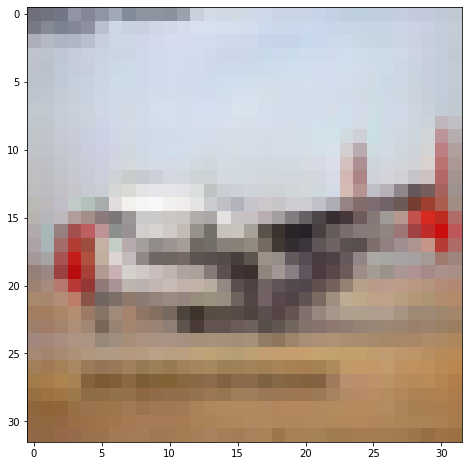

In [19]:
show_image(*train_dataset[1099])

# Training and Validation Dataset

While building real world machine learning models we should have 3 sets of data :



*   Training Set
*   Validation Set 
*   Test Set   



In [20]:
random_seed = 42
torch.manual_seed(random_seed);

In [21]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, valid_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(45000, 5000)

use jovian library to log the dataset info

In [22]:
jovian.log_dataset(dataset_url = dataset_url,
                   val_size = val_size,
                   random_seed=random_seed)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Dataset logged.


Create DataLoaders

In [23]:
from torch.utils.data.dataloader import DataLoader

In [24]:
batch_size = 128

In [25]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)br

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
from torchvision.utils import make_grid

In [32]:
def show_batches(dl):

  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(18,12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


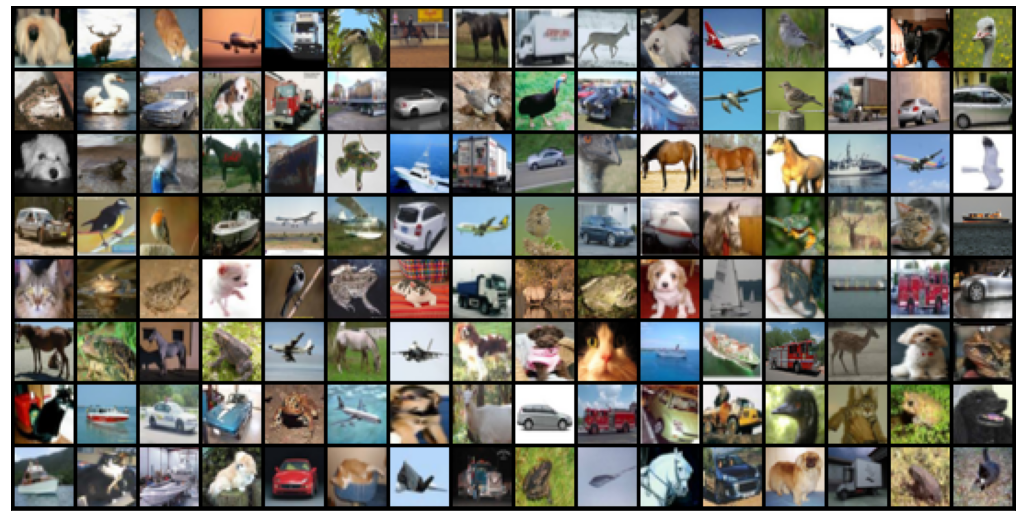

In [33]:
show_batches(train_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


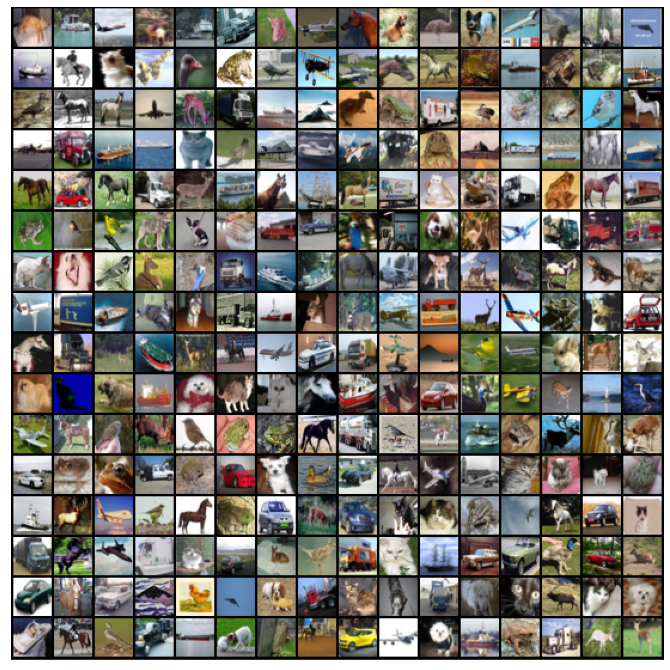

In [34]:
show_batches(valid_loader)

# Define Model

In [39]:
import torch.nn as nn
import torch.nn.functional as F

In [40]:
conv = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)

In [44]:
pool = nn.MaxPool2d(2,2)

3 is the input channel size i.e. R,G,B and 8 is the number of output channels after convolutions

In [45]:
for images, labels in train_loader:
  print(images.shape)
  out = conv(images)
  out = pool(out)
  print(out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 16, 16])


The output have 8 channels. And after pooling the dimension of the image is reduced by half

In [48]:
conv.weight[0]

tensor([[[-0.1353, -0.0272,  0.0978],
         [ 0.1194, -0.1226, -0.1079],
         [-0.1055, -0.0540,  0.1759]],

        [[-0.1845,  0.0184, -0.1037],
         [-0.1075,  0.0798, -0.1765],
         [-0.0663,  0.0979,  0.0704]],

        [[ 0.1275,  0.0763,  0.1296],
         [-0.1559, -0.0474, -0.0359],
         [-0.0612, -0.0981, -0.0970]]], grad_fn=<SelectBackward>)

In [49]:
conv.weight.shape

torch.Size([8, 3, 3, 3])

use nn.Sequential to stack many layers into single model

In [50]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [51]:
for images, labels in train_loader:
  print(images.shape)
  out = simple_model(images)
  print(out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 16, 16])


Extend nn.Module Class to extend and create an **ImageClassificationBaseline** Class for containing general functions required for image classification

In [55]:
class ImageClassificationBaseline(nn.Module):
  
  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = self.accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}

  def accuracy(self, outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / preds.numel())

  def validation_step_end(self, val_outputs, train_outputs):
    val_batch_losses = [x['val_loss'] for x in val_outputs]
    val_epoch_loss = torch.stack(val_batch_losses).mean()
    val_batch_acc = [x['val_acc'] for x in val_outputs]
    val_epoch_acc = torch.stack(val_batch_acc).mean()

    train_batch_losses = [x['val_loss'] for x in train_outputs]
    train_epoch_loss = torch.stack(train_batch_losses).mean()
    train_batch_acc = [x['val_acc'] for x in train_outputs]
    train_epoch_acc = torch.stack(train_batch_acc).mean()

    return {'train_loss':train_epoch_loss.item(), 'train_acc':train_epoch_acc.item(), 'val_loss':val_epoch_loss.item(), 'val_acc':val_epoch_acc.item()}

  def epoch_end(self, epoch, num_epochs, results):
    print("Epoch [{}/{}]: train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, num_epochs, 
                                    results['train_loss'], results['train_acc'], results['val_loss'], results['val_acc']))

The above class is the baseline model used for image classification

We should extend the above class to our custom model according to custom problem or model. 

We use nn.Sequential to define our model in a new class

In [58]:
class Cifar10Model(ImageClassificationBaseline):

  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        
        # input: 3 x 32 x 32
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        # output: 32 x 32 x 32
        nn.ReLU(),
        # output: 32 x 32 x 32
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        # output: 64 x 32 x 32
        nn.ReLU(),
        # output: 64 x 32 x 32
        nn.MaxPool2d(2,2),
        # output: 64 x 16 x 16

        nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
        # output: 128 x 16 x 16
        nn.ReLU(),
        # output: 128 x 16 x 16
        nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
        # output: 128 x 16 x 16
        nn.ReLU(),
        # output: 128 x 16 x 16
        nn.MaxPool2d(2,2),
        # output: 128 x 8 x 8

        nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2) ,
        # Output: 256 x 4 x 4

        nn.Flatten(),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
        )
    
  def forward(self, xb):
    return self.network(xb)


In [59]:
model = Cifar10Model()

In [60]:
model

Cifar10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

In [63]:
for images, labels in train_loader:
  print("Images shape: ",images.shape)
  out = model(images)
  print("out.shape : ",out.shape)
  print("out[0]: ",out[0])
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Images shape:  torch.Size([128, 3, 32, 32])
out.shape :  torch.Size([128, 10])
out[0]:  tensor([-0.0236, -0.0296, -0.0064,  0.0202, -0.0350, -0.0003, -0.0279, -0.0120,
        -0.0188, -0.0112], grad_fn=<SelectBackward>)


Check and configure helper functions to train model in GPU

In [67]:
def get_default_device():
  """Pick GPU if availabel, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move data or model to GPU"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data into device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yeild a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches"""
    return len(self.dl)

In [69]:
device = get_default_device()
device

device(type='cuda')

Load Data to GPU

In [70]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
to_device(model, device)

Cifar10Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feature

# Train Model

In [72]:
@torch.no_grad()
def evaluate(model, val_loader, train_loader):
  model.eval()
  val_outputs = [model.validation_step(batch) for batch in val_loader]
  train_outputs = [model.validation_step(batch) for batch in train_loader]
  return model.validation_step_end(val_outputs, train_outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func = torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []
  for epoch in range(1,epochs+1):
    # Training phase
    model.train()
    for batch in train_dl:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # validation phase
    results = evaluate(model, valid_dl, train_dl)
    model.epoch_end(epoch, epochs, results)
    history.append(results)

  return history

In [73]:
model = to_device(Cifar10Model(), device)

In [74]:
evaluate(model, valid_loader, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'train_acc': 0.1001124456524849,
 'train_loss': 2.3029847145080566,
 'val_acc': 0.0985523909330368,
 'val_loss': 2.303210973739624}

Define some hyperparameters

In [75]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

Record these hyperparameters

In [76]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs':num_epochs,
    'opt_func':opt_func.__name__,
    'batch_size':batch_size,
    'lr':lr,
})

[jovian] Hyperparams logged.


In [77]:
history = fit(num_epochs, lr, model, train_loader, valid_loader, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/10]: train_loss: 1.4502, train_acc: 0.4622, val_loss: 1.4460, val_acc: 0.4624
Epoch [2/10]: train_loss: 1.0716, train_acc: 0.6144, val_loss: 1.1248, val_acc: 0.5958
Epoch [3/10]: train_loss: 0.7891, train_acc: 0.7232, val_loss: 0.8801, val_acc: 0.6928
Epoch [4/10]: train_loss: 0.6509, train_acc: 0.7697, val_loss: 0.8006, val_acc: 0.7256
Epoch [5/10]: train_loss: 0.5346, train_acc: 0.8118, val_loss: 0.7486, val_acc: 0.7479
Epoch [6/10]: train_loss: 0.4051, train_acc: 0.8613, val_loss: 0.7063, val_acc: 0.7663
Epoch [7/10]: train_loss: 0.3477, train_acc: 0.8815, val_loss: 0.7628, val_acc: 0.7677
Epoch [8/10]: train_loss: 0.2419, train_acc: 0.9190, val_loss: 0.7582, val_acc: 0.7804
Epoch [9/10]: train_loss: 0.1792, train_acc: 0.9412, val_loss: 0.8057, val_acc: 0.7749
Epoch [10/10]: train_loss: 0.1313, train_acc: 0.9596, val_loss: 0.8391, val_acc: 0.7817


In [78]:
history

[{'train_acc': 0.462158203125,
  'train_loss': 1.4502224922180176,
  'val_acc': 0.46239662170410156,
  'val_loss': 1.4459865093231201},
 {'train_acc': 0.6143613457679749,
  'train_loss': 1.0715994834899902,
  'val_acc': 0.5958409905433655,
  'val_loss': 1.1248482465744019},
 {'train_acc': 0.7231988310813904,
  'train_loss': 0.7891423106193542,
  'val_acc': 0.6927504539489746,
  'val_loss': 0.8800986409187317},
 {'train_acc': 0.769691526889801,
  'train_loss': 0.6509448885917664,
  'val_acc': 0.7255514860153198,
  'val_loss': 0.8005911707878113},
 {'train_acc': 0.8118242621421814,
  'train_loss': 0.5345731973648071,
  'val_acc': 0.7479435205459595,
  'val_loss': 0.7485999464988708},
 {'train_acc': 0.861278772354126,
  'train_loss': 0.4051346480846405,
  'val_acc': 0.7662798762321472,
  'val_loss': 0.7062885165214539},
 {'train_acc': 0.881483256816864,
  'train_loss': 0.34770336747169495,
  'val_acc': 0.767693042755127,
  'val_loss': 0.7628039717674255},
 {'train_acc': 0.919004499912262,

Log the metrics 

In [79]:
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   train_acc=history[-1]['train_acc'],
                   val_loss=history[-1]['val_loss'],
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [80]:
history1 = fit(num_epochs, lr, model, train_loader, valid_loader, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/10]: train_loss: 0.1001, train_acc: 0.9673, val_loss: 0.9935, val_acc: 0.7764
Epoch [2/10]: train_loss: 0.0754, train_acc: 0.9754, val_loss: 1.0568, val_acc: 0.7800
Epoch [3/10]: train_loss: 0.0703, train_acc: 0.9764, val_loss: 1.1101, val_acc: 0.7822
Epoch [4/10]: train_loss: 0.0698, train_acc: 0.9756, val_loss: 1.1671, val_acc: 0.7704
Epoch [5/10]: train_loss: 0.0787, train_acc: 0.9722, val_loss: 1.2093, val_acc: 0.7680
Epoch [6/10]: train_loss: 0.0688, train_acc: 0.9773, val_loss: 1.1990, val_acc: 0.7676
Epoch [7/10]: train_loss: 0.0700, train_acc: 0.9762, val_loss: 1.2986, val_acc: 0.7692
Epoch [8/10]: train_loss: 0.0443, train_acc: 0.9843, val_loss: 1.3011, val_acc: 0.7783
Epoch [9/10]: train_loss: 0.0394, train_acc: 0.9876, val_loss: 1.3525, val_acc: 0.7833
Epoch [10/10]: train_loss: 0.0470, train_acc: 0.9840, val_loss: 1.2793, val_acc: 0.7761


In [81]:
history += history1

In [84]:
import pandas as pd

In [89]:
history = pd.DataFrame(history)

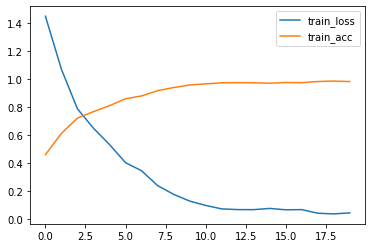

In [90]:
pd.DataFrame({'train_loss':history['train_loss'],'train_acc':history['train_acc']}).plot()

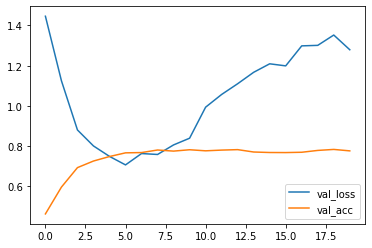

In [92]:
pd.DataFrame({'val_loss':history['val_loss'],'val_acc':history['val_acc']}).plot()

# Testing with Individuaql Images

In [95]:
test_dataset = ImageFolder(data_dir + '/test',transform = ToTensor())

In [96]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return train_dataset.classes[preds[0].item()]

Label : airplane , Predicted:  airplane


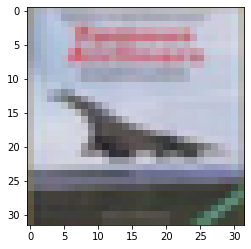

In [107]:
img, label = test_dataset[0]
plt.imshow(img.permute(1,2,0))
print('Label :',train_dataset.classes[label],', Predicted: ',predict_image(img, model))

Label : frog , Predicted:  frog


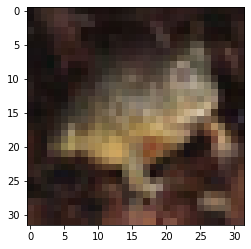

In [108]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1,2,0))
print('Label :',train_dataset.classes[label],', Predicted: ',predict_image(img, model))

Label : automobile , Predicted:  truck


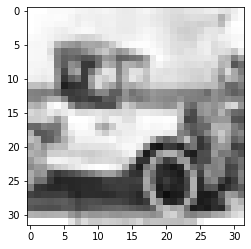

In [109]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1,2,0))
print('Label :',train_dataset.classes[label],', Predicted: ',predict_image(img, model))

## Test the model on Test Data

In [110]:
test_loader = DeviceDataLoader(DataLoader(test_dataset,batch_size*2,num_workers=4,pin_memory=True),device)
result = evaluate(model,test_loader, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [111]:
result

{'train_acc': 0.9840692281723022,
 'train_loss': 0.046885810792446136,
 'val_acc': 0.775390625,
 'val_loss': 1.313920021057129}

In [112]:
jovian.log_metrics(test_loss=result['val_loss'],test_acc=result['val_acc'])

[jovian] Metrics logged.


# Saving and loading the model

In [113]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

# Update in Jovian

In [35]:
!pip install jovian --upgrade --quiet

In [36]:
import jovian

In [114]:
# Execute this to save new versions of the notebook
jovian.commit(project="04-image-classification-ccn")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/developer-jnk/04-image-classification-ccn


'https://jovian.ai/developer-jnk/04-image-classification-ccn'